In [65]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams, colors
import seaborn as sns
import logging
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score, LearningCurveDisplay, ShuffleSplit
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from keras.models import load_model
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from functools import partial
from sklearn.ensemble import StackingClassifier
from bayes_opt import BayesianOptimization
from joblib import dump, load, Parallel, delayed
import anndata
from scipy.stats import spearmanr
from sklearnex import patch_sklearn
patch_sklearn()
from tensorflow.keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import skimage
import time
import subprocess
import sys
import warnings
warnings.filterwarnings("ignore")
import pickle as pkl
from sccd45ra import cd45ra_infer
from rpy2.robjects import pandas2ri
import rpy2.rinterface_lib.callbacks
import anndata2ri
import anndata

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [107]:
bi_palette = ['#E8D2A0','#030200']

In [108]:
rb_palette = ['#FF1E00','#0073FF']

In [66]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

-----
anndata     0.8.0
scanpy      1.9.3
-----
PIL                                         9.2.0
aa8f2297d25b4dc6fd3d98411eb3ba53823c4f42    NA
absl                                        NA
anndata2ri                                  1.1
asttokens                                   NA
astunparse                                  1.6.3
backcall                                    0.2.0
bayes_opt                                   NA
beta_ufunc                                  NA
binom_ufunc                                 NA
brotli                                      NA
cairo                                       1.23.0
certifi                                     2022.09.24
cffi                                        1.15.1
charset_normalizer                          2.1.1
cloudpickle                                 2.2.0
colorama                                    0.4.4
cycler                                      0.10.0
cython_runtime                              NA
daal4py             

In [67]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
.libPaths(.libPaths('C:\\Users\\16220\\AppData\\Local\\R\\win-library\\4.3'))

# Load all the R libraries we will be using in the notebook
library(scran)
library(Matrix)
library(Seurat)
library(RColorBrewer)
library(slingshot)
library(monocle)
library(gam)
library(ggplot2)
library(plyr)
library(MAST)
library(clusterExperiment)
library(SingleCellExperiment)
library(monocle3)
library(SeuratWrappers)
library(destiny)
library(circlize)

Exception ignored from cffi callback <function _consolewrite_ex at 0x00000264EEBA8AF0>:
Traceback (most recent call last):
  File "C:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 133, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
  File "C:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\rpy2\rinterface_lib\conversion.py", line 138, in _cchar_to_str_with_maxlen
    s = ffi.string(c, maxlen).decode(encoding)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xd4 in position 0: invalid continuation byte
Exception ignored from cffi callback <function _consolewrite_ex at 0x00000264EEBA8AF0>:
Traceback (most recent call last):
  File "C:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 133, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
  File "C:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\rpy2\rinterface_lib\


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

Exception ignored from cffi callback <function _consolewrite_ex at 0x00000264EEBA8AF0>:
Traceback (most recent call last):
  File "C:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 133, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
  File "C:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\rpy2\rinterface_lib\conversion.py", line 138, in _cchar_to_str_with_maxlen
    s = ffi.string(c, maxlen).decode(encoding)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xd4 in position 1: invalid continuation byte
Exception ignored from cffi callback <function _consolewrite_ex at 0x00000264EEBA8AF0>:
Traceback (most recent call last):
  File "C:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 133, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
  File "C:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\rpy2\rinterface_lib\

In [144]:
from matplotlib.colors import LinearSegmentedColormap
values = [0,1]
colors = [(227, 227, 227), (255, 42, 18)]
norm = plt.Normalize(min(values), max(values))
my_cmap = LinearSegmentedColormap.from_list(
    '', [(norm(value), tuple(np.array(color) / 255)) for value, color in zip(values, colors)])

In [305]:
adata = sc.read_h5ad('GSE164378_processed.h5ad')

In [ ]:
#!pip install sccd45ra
#from sccd45ra import cd45ra_infer
import time
start = time.time()
cd45ra_infer(adata)
end = time.time()
print(end-start)

This function takes normalized, log transformed input
146.59942436218262


In [ ]:
t = skimage.filters.threshold_otsu(adata_T.obs['CD45RA'])
print("Found automatic threshold t = {}.".format(t))
adata_T.obs['CD45RA_True_Label'] =  'Negative'
adata_T.obs['CD45RA_True_Label'][adata_T.obs['CD45RA']>t] = 'Positive'

Found automatic threshold t = 2.3962621688842773.


In [ ]:
y_true = adata.obs['CD45RA_label'] == 'Positive'

In [ ]:
y_predict = adata.obs['CD45RA_predict'] == 'True'

In [ ]:
accuracy_score(y_true,y_predict)

0.8231109516977523

In [ ]:
precision_score(y_true,y_predict)

0.9334302548014385

In [ ]:
recall_score(y_true,y_predict)

0.7073114164782281

In [ ]:
print(np.around(np.sum(adata[adata.obs['leiden'] == '7',:].obs['missed'] == 'True')/np.sum(adata.obs['leiden'] == '7'),4))

0.2742


In [ ]:
print(np.around(np.sum(adata[adata.obs['leiden'] == '0',:].obs['missed'] == 'True')/np.sum(adata.obs['leiden'] == '0'),4))

0.4121


In [ ]:
print(np.around(np.sum(adata[adata.obs['leiden'] == '4',:].obs['missed'] == 'True')/np.sum(adata.obs['leiden'] == '4'),4))

0.3647


computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Leiden clustering
    finished: found 16 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:03)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


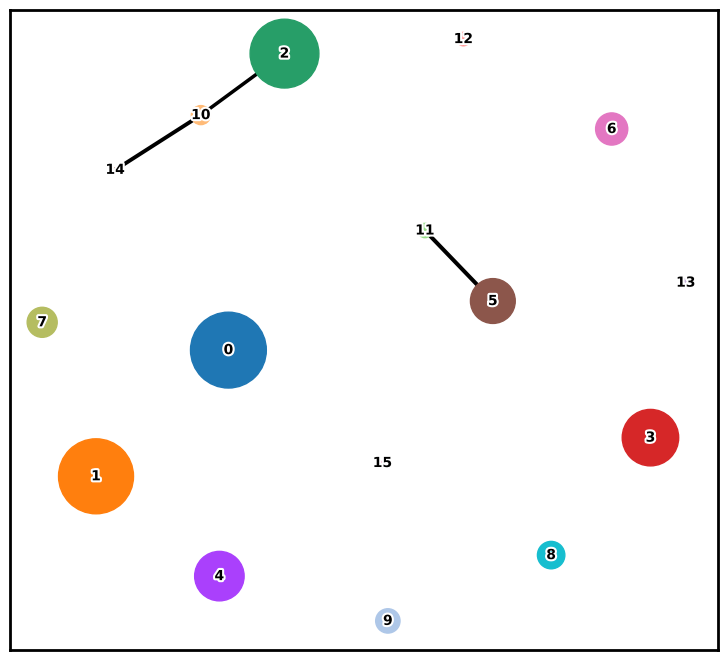

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:19)


In [ ]:
sc.pp.neighbors(adata)
sc.tl.leiden(adata, resolution = 0.5)
sc.tl.paga(adata, groups='leiden')
sc.pl.paga(adata,threshold = 0.3, labels=None, fontsize = 10, fontoutline = 3,node_size_scale = 3,node_size_power = 1,random_state = 0)
sc.tl.umap(adata, min_dist = 0.01, spread = 2,init_pos = 'paga')

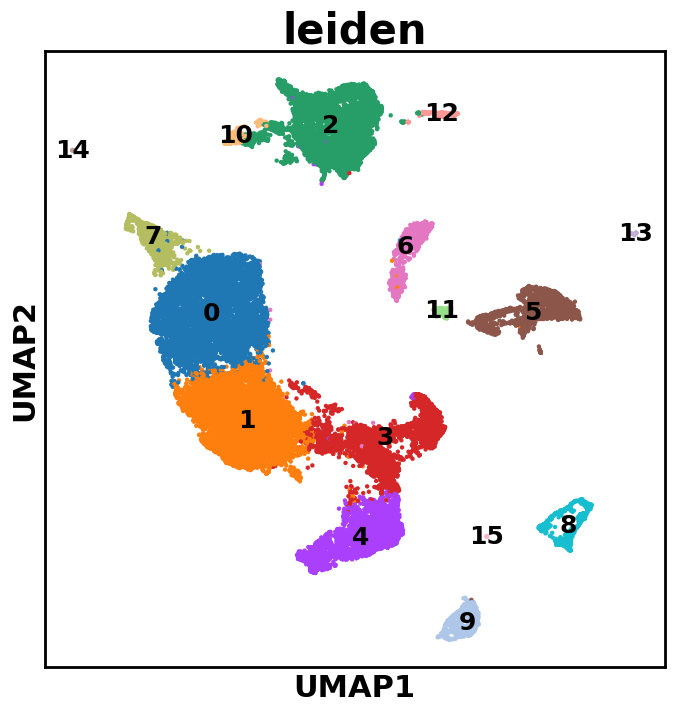

In [ ]:
plt.close()
plt.rcParams['axes.linewidth'] = 2
fig = sc.pl.umap(adata, color = ['leiden'],size = 40, legend_loc = 'on data',  ncols = 4,  return_fig = True, legend_fontsize = 'large')
ax = fig.get_axes()
for i in range(0,len(ax)):
    ax[i].xaxis.label.set_fontsize(22)
    ax[i].xaxis.label.set_fontweight('bold')
    ax[i].yaxis.label.set_fontsize(22)
    ax[i].title.set_fontsize(30)
    ax[i].yaxis.label.set_fontweight('bold')
    ax[i].title.set_fontweight('bold')
plt.savefig('overall_map.png')

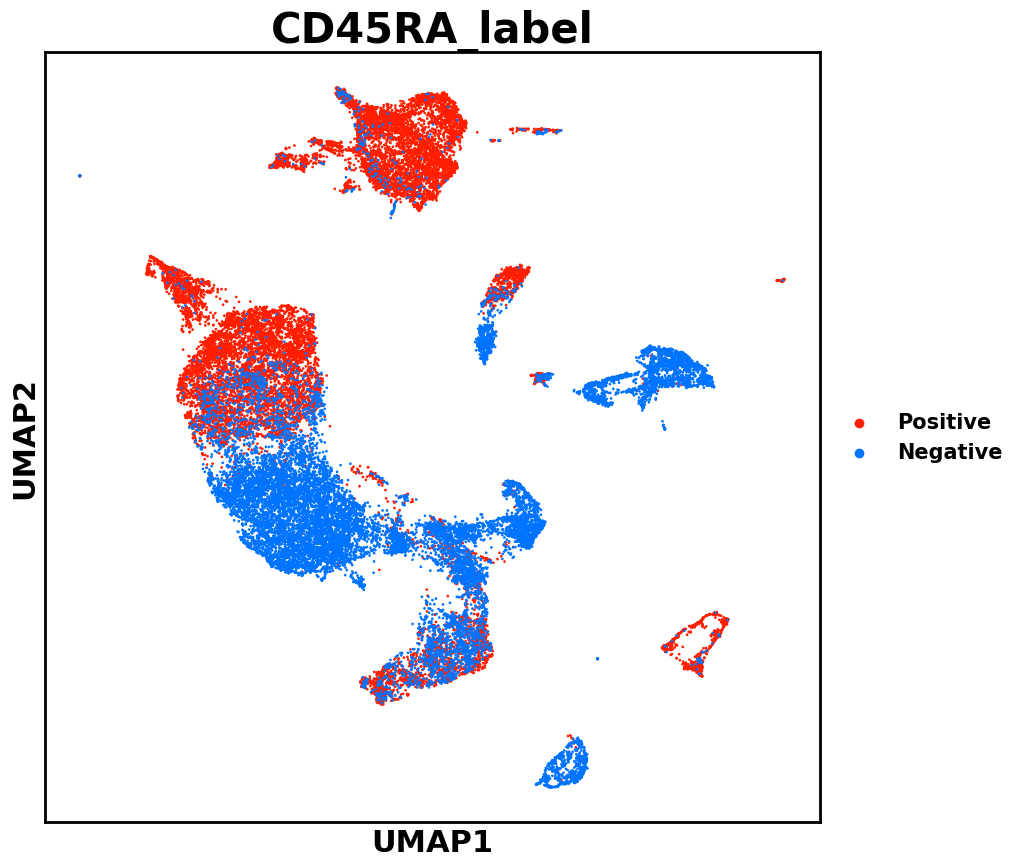

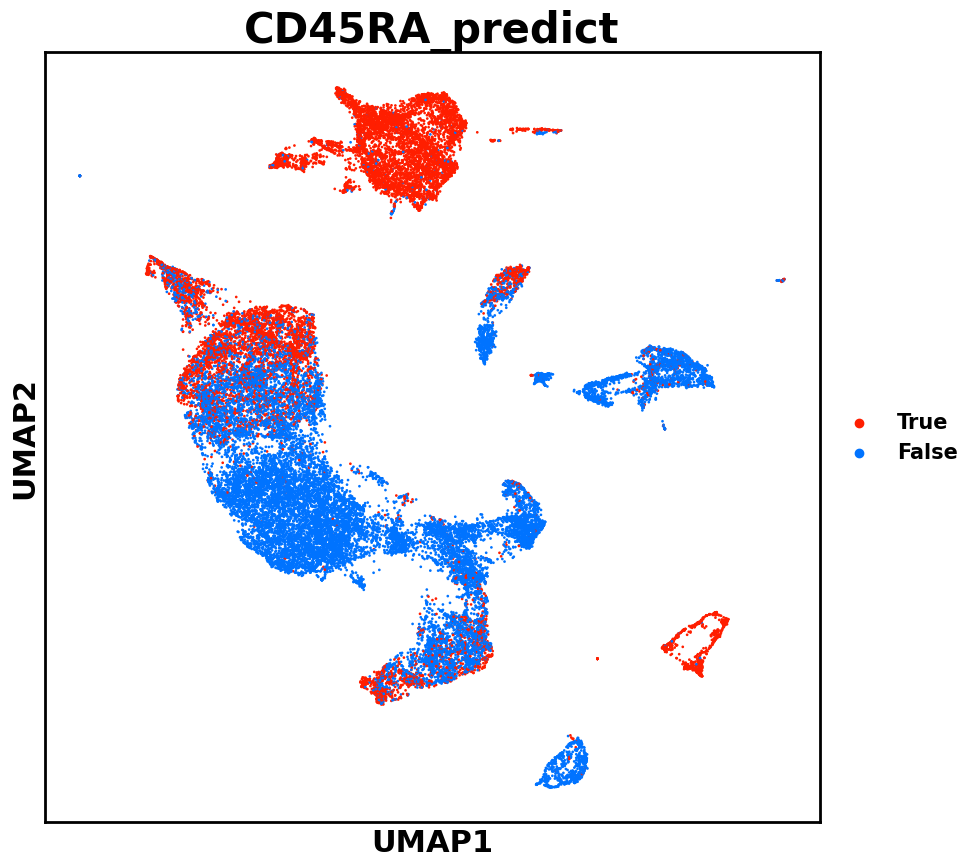

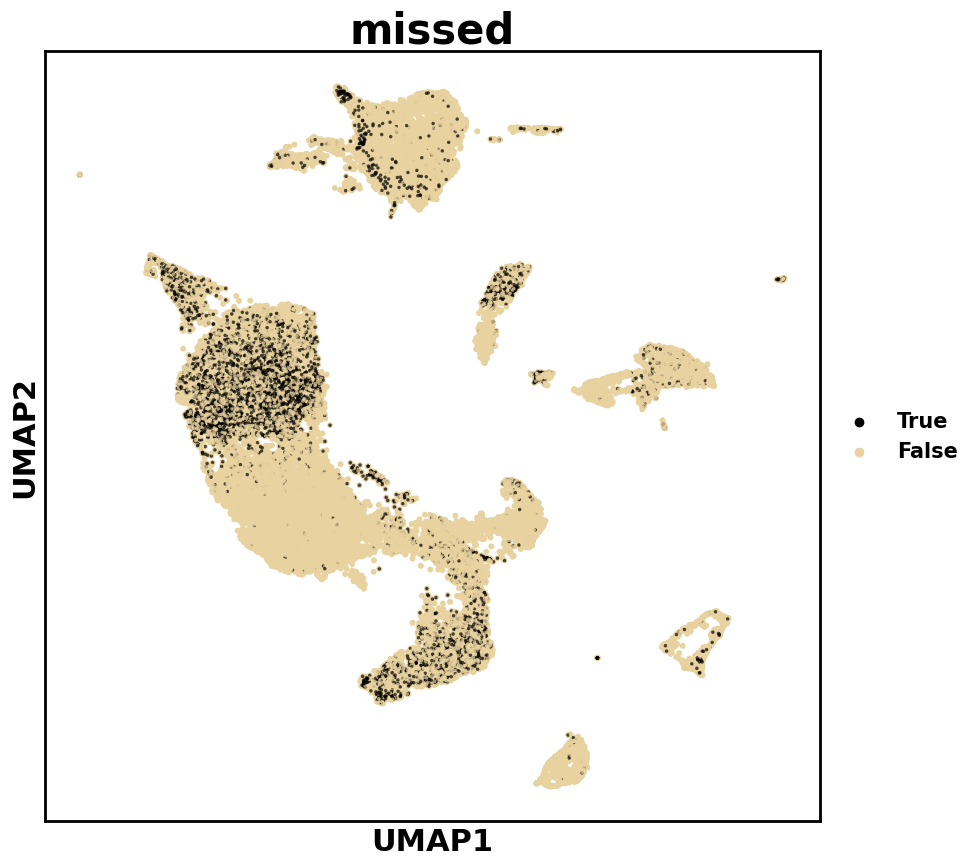

In [34]:
plt.rcParams.update({'figure.figsize': [10,10],'font.size': 15, 'font.weight': 'heavy','axes.linewidth':2})
adata.obs['missed'] = (y_true != y_predict)
adata.obs['missed'] = adata.obs['missed'].astype('str').astype('category').cat.reorder_categories(['True','False'])
adata.obs['CD45RA_predict'] = adata.obs['CD45RA_predict'].astype('str').astype('category')
adata.obs['CD45RA_label'] =  adata.obs['CD45RA_label'].cat.reorder_categories(['Positive','Negative'])
adata.obs['CD45RA_predict'] =  adata.obs['CD45RA_predict'].cat.reorder_categories(['True','False'])
fig = sc.pl.umap(adata,color = ['CD45RA_label'],palette = ['#FF1E00','#0073FF'],size =15,ncols = 1, return_fig = True)
ax = fig.get_axes()
for i in range(0,len(ax)):
    ax[i].xaxis.label.set_fontsize(22)
    ax[i].xaxis.label.set_fontweight('bold')
    ax[i].yaxis.label.set_fontsize(22)
    ax[i].title.set_fontsize(30)
    ax[i].yaxis.label.set_fontweight('bold')
    ax[i].title.set_fontweight('bold')
fig.savefig('performance_on_seurat4_1.png',bbox_inches='tight')
fig = sc.pl.umap(adata,color = ['CD45RA_predict'],palette = ['#FF1E00','#0073FF'],size =15,ncols = 1, return_fig = True)
ax = fig.get_axes()
for i in range(0,len(ax)):
    ax[i].xaxis.label.set_fontsize(22)
    ax[i].xaxis.label.set_fontweight('bold')
    ax[i].yaxis.label.set_fontsize(22)
    ax[i].title.set_fontsize(30)
    ax[i].yaxis.label.set_fontweight('bold')
    ax[i].title.set_fontweight('bold')
fig.savefig('performance_on_seurat4_2.png',bbox_inches='tight')

fig = sc.pl.umap(adata,color = ['missed'],palette = ['#030200','#E8D2A0'],add_outline  = True, outline_color   = ('#E8D2A0','#E8D2A0'),size =25,ncols = 1,return_fig = True)
ax = fig.get_axes()
for i in range(0,len(ax)):
    ax[i].xaxis.label.set_fontsize(22)
    ax[i].xaxis.label.set_fontweight('bold')
    ax[i].yaxis.label.set_fontsize(22)
    ax[i].title.set_fontsize(30)
    ax[i].yaxis.label.set_fontweight('bold')
    ax[i].title.set_fontweight('bold')
fig.savefig('missed_on_seurat4.png',bbox_inches='tight')            

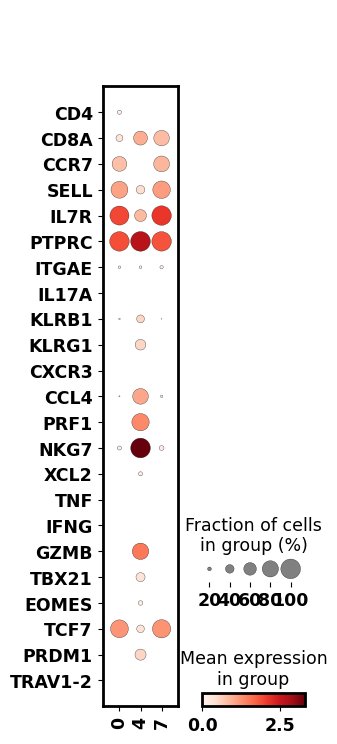

In [48]:
plt.rcParams.update({'font.size': 15, 'font.weight': 'heavy','axes.linewidth':2})
#plt.rcParams.update(plt.rcParamsDefault)


sc.pl.dotplot(adata[adata.obs['leiden'].isin(['0','4','7']),:],['CD4','CD8A','CCR7','SELL',
                               'IL7R','PTPRC','ITGAE','IL17A','KLRB1','KLRG1','CXCR3','CCL4',
                                'PRF1','NKG7','XCL2','TNF','IFNG','GZMB','TBX21','EOMES','TCF7','PRDM1','TRAV1-2'],groupby = 'leiden' ,  
              swap_axes = True,dot_min = 0.1, save= 'miss_cluster_exp.png')

In [56]:
adata_concat = sc.read_h5ad('GSE144434_processed.h5ad')

In [26]:
#load the model
best_linear_svm = load('best_linear_svm.joblib')
best_linear_svm_features=pd.read_excel('Used_features.xlsx')['LINEAR  SVM'].dropna().values.tolist()
best_rbf_svm = load('best_rbf_svm.joblib')
best_rbf_svm_features=pd.read_excel('Used_features.xlsx')['RBF SVM'].dropna().values.tolist()
best_lr = load('best_lr.joblib')
best_lr_features=pd.read_excel('Used_features.xlsx')['LR'].dropna().values.tolist()
best_mlp_linear = load_model('best_mlp_linear.h5')
best_stack = load('best_stack.joblib')
best_stack_features=pd.read_excel('Used_features.xlsx')['Stack'].dropna().values.tolist()
best_mlp_rbf = load_model('best_mlp_rbf.h5')

In [103]:
sc.pp.filter_genes(adata_concat, min_cells = 10)

In [104]:
genedf = pd.DataFrame(adata_concat.X.A, index = adata_concat.obs_names, columns = adata_concat.var_names)

In [105]:
X = genedf
y = adata_concat.obs['batch'].astype(int)==1
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

In [76]:
counts = adata_concat.layers['counts'].T
rownames = adata_concat.var_names
colnames = adata_concat.obs_names
CD45RA_label = (adata_concat.obs['batch'].astype(int)==1).astype(str)

In [77]:
%%R -i counts -i colnames -i rownames -i CD45RA_label

colnames(counts) = colnames
rownames(counts) = rownames
srat <- CreateSeuratObject(counts = counts, min.cells = 0, min.features = 0, assay = "RNA")
srat[['CD45RA_label']] = CD45RA_label

saveRDS(srat,'e:/GSE144434.rds')

In [1]:
## Send to HPC for multimodal reference matching and got 'predicted_ADT.rds'

In [83]:
%%R -o data_df 
#after doing the seurat4
predicted_ADT = readRDS('e:/predicted_ADT.rds')@data
data_df <- as.data.frame(predicted_ADT)

<Axes: >

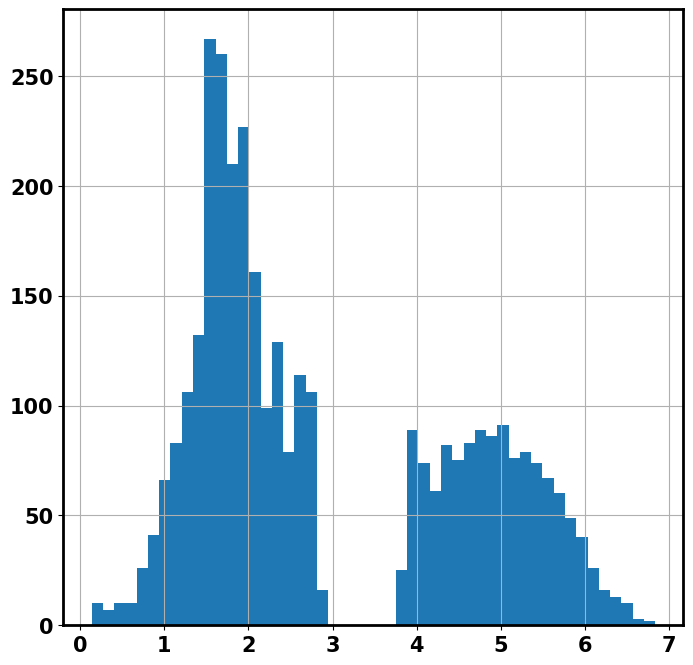

In [88]:
adata_concat.obs['antibody'].hist(bins = 50)

<Axes: >

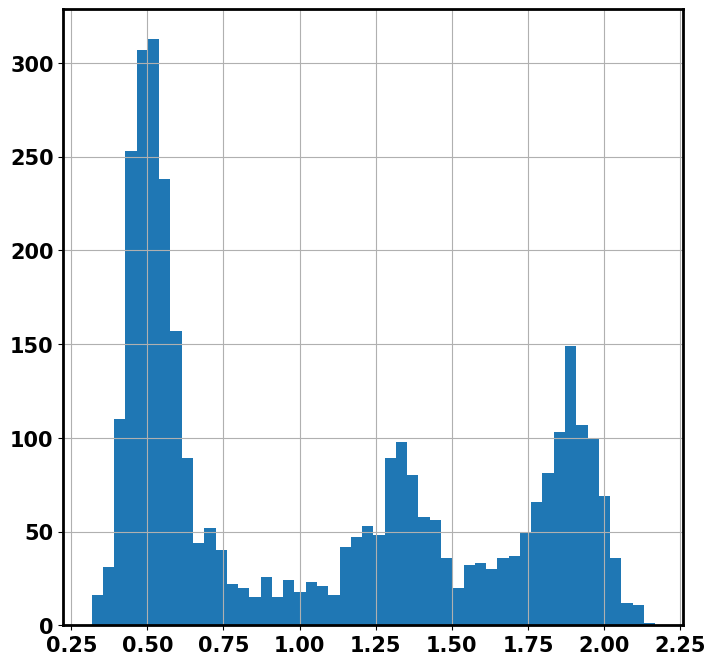

In [86]:
s4predicted = data_df.T['CD45RA']
s4predicted.hist(bins = 50)

In [140]:
t = skimage.filters.threshold_otsu(s4predicted)
print("Found automatic threshold t = {}.".format(t))

Found automatic threshold t = 1.093905176226653.


In [149]:
adata_concat.obs['Seurat4_predicted_label'] = s4predicted>t
adata_concat.obs['Seurat4_predicted_label'] = adata_concat.obs['s4_predicted'].astype(str)
adata_concat.obs['Seurat4_predicted'] = s4predicted

In [120]:
adata_concat.obs['CD45RA_True_Label'] =  'Negative'
adata_concat.obs['CD45RA_True_Label'][adata_concat.obs['batch'] == '1'] = 'Positive'
adata_concat.obs['Seurat4_missed'] = (adata_concat.obs['CD45RA_True_Label'] == 'Positive') != (adata_concat.obs['Seurat4_predicted_label'] == 'True')
adata_concat.obs['Seurat4_missed'] = adata_concat.obs['Seurat4_missed'].astype(str)
adata_concat

In [150]:
adata_train = adata_concat[X_train.index,:]
adata_val = adata_concat[X_val.index,:]

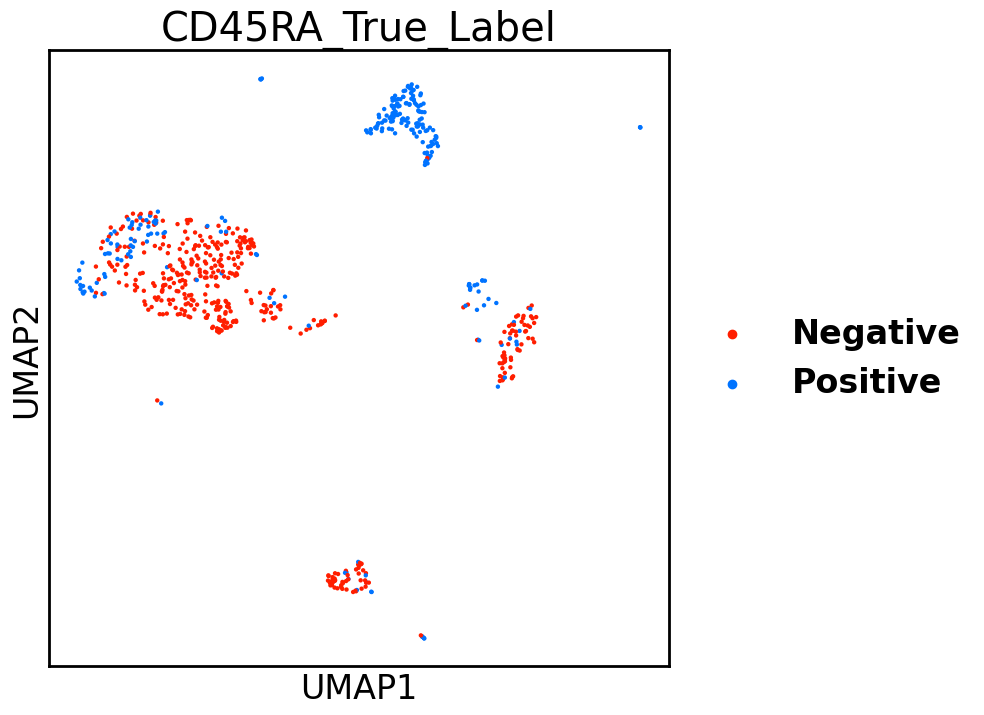

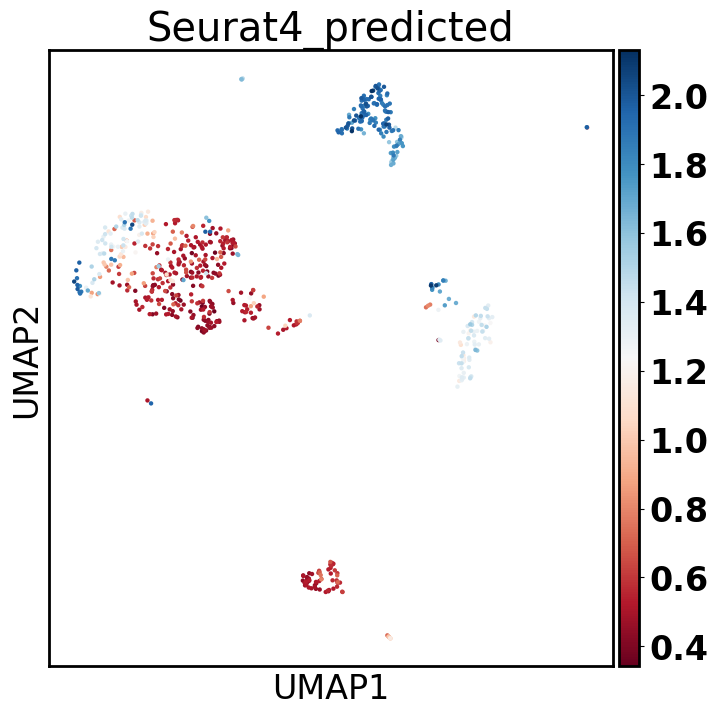

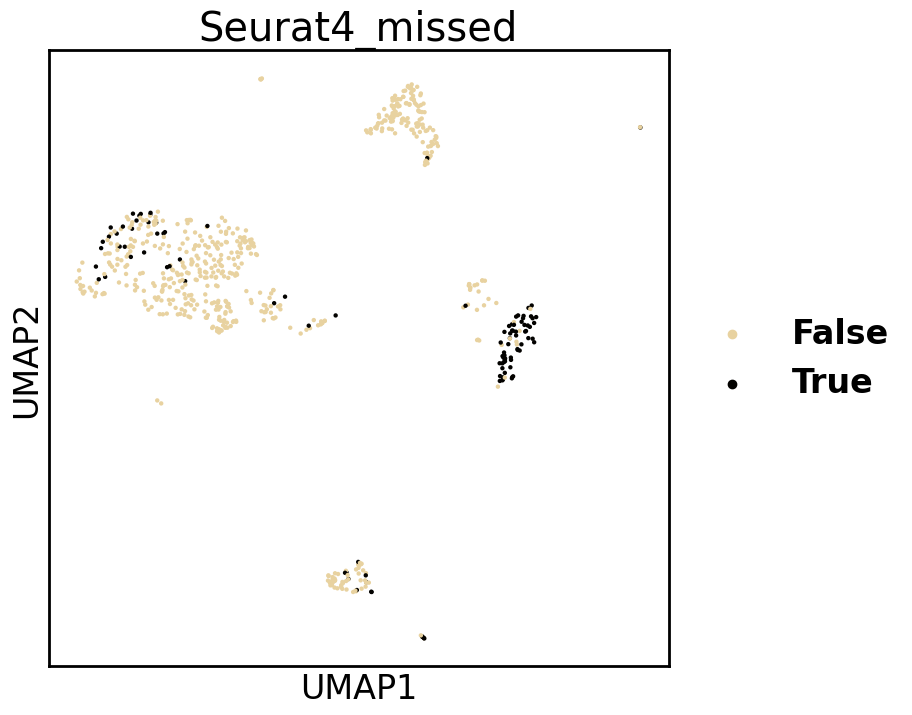

In [172]:
plt.rcParams.update({'font.size': 24, 'font.weight': 'heavy','axes.linewidth':2})
sc.pl.umap(adata_val, color = ['CD45RA_True_Label'],ncols = 1, palette = rb_palette, size =40)
sc.pl.umap(adata_val, color = ['Seurat4_predicted'],ncols = 1, cmap = 'RdBu', size =40,save = 'Seurat4_predicted.png')
sc.pl.umap(adata_val, color = ['Seurat4_missed'],ncols = 1, palette = bi_palette, size =40,save = 'seurat4_missed.png')

In [129]:
cd45raneg = sc.read_h5ad('GSE150132_processed.h5ad')

In [130]:
counts = cd45raneg.layers['counts'].T
rownames = cd45raneg.var_names
colnames = cd45raneg.obs_names

In [131]:
%%R -i counts -i colnames -i rownames

colnames(counts) = colnames
rownames(counts) = rownames
srat <- CreateSeuratObject(counts = counts, min.cells = 0, min.features = 0, assay = "RNA")

saveRDS(srat,'e:/GSE150132.rds')

In [132]:
%%R -o data_df 
#after doing the seurat4
predicted_ADT = readRDS('e:/predicted_ADT_allneg.rds')@data
data_df <- as.data.frame(predicted_ADT)

<Axes: >

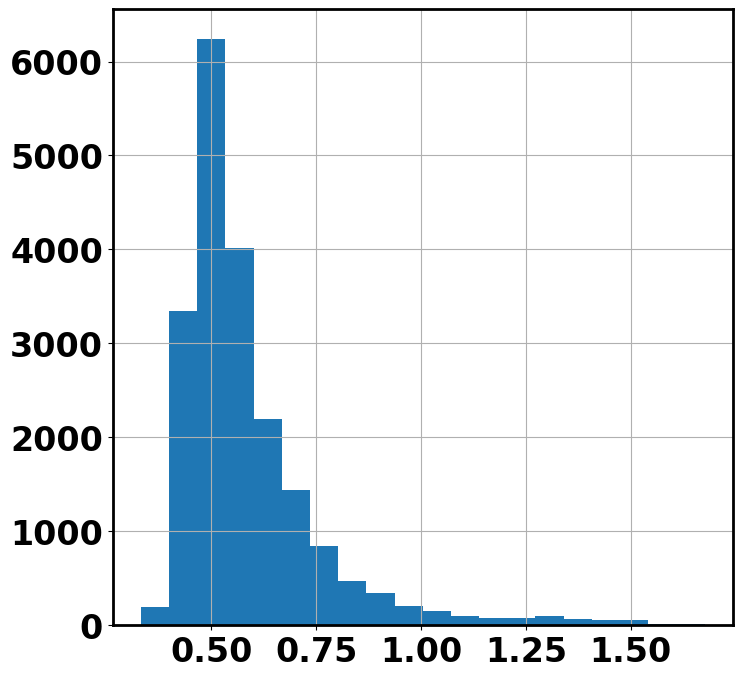

In [138]:
data_df.T['CD45RA'].hist(bins = 20)

In [142]:
cd45raneg.obs['Seurat4_predicted_level'] = data_df.T['CD45RA']

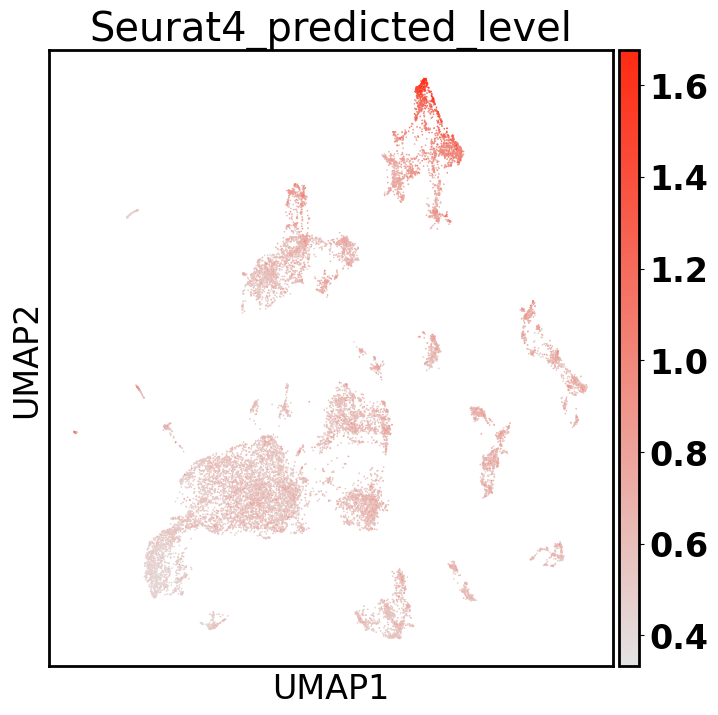

In [147]:
sc.pl.umap(cd45raneg, color = 'Seurat4_predicted_level',cmap = my_cmap,save = 'Seurat4_predicted_CD45RA_level.png')

In [136]:
t = skimage.filters.threshold_otsu(data_df.T['CD45RA'])
print("Found automatic threshold t = {}.".format(t))

Found automatic threshold t = 0.7548376768405614.


In [139]:
adata_concat.obs['Seurat4_predicted'] = s4predicted>1.25
adata_concat.obs['Seurat4_predicted'] = adata_concat.obs['s4_predicted'].astype(str)

In [120]:
adata_concat.obs['CD45RA_True_Label'] =  'Negative'
adata_concat.obs['CD45RA_True_Label'][adata_concat.obs['batch'] == '1'] = 'Positive'
adata_concat.obs['Seurat4_missed'] = (adata_concat.obs['CD45RA_True_Label'] == 'Positive') != (adata_concat.obs['Seurat4_predicted'] == 'True')
adata_concat.obs['Seurat4_missed'] = adata_concat.obs['Seurat4_missed'].astype(str)

In [122]:
adata_train = adata_concat[X_train.index,:]
adata_val = adata_concat[X_val.index,:]

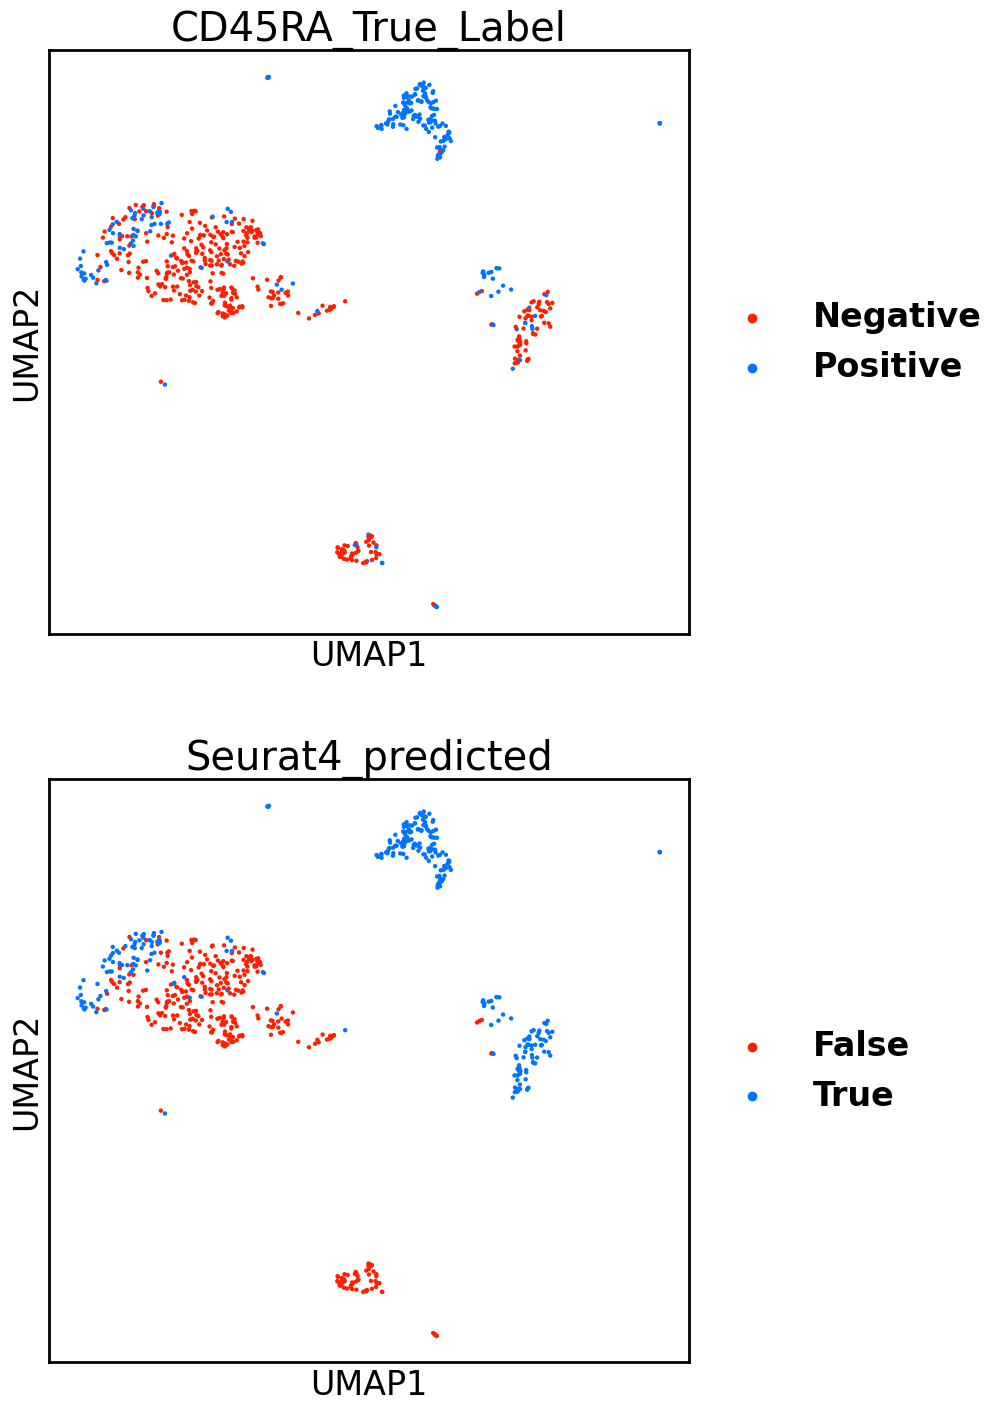

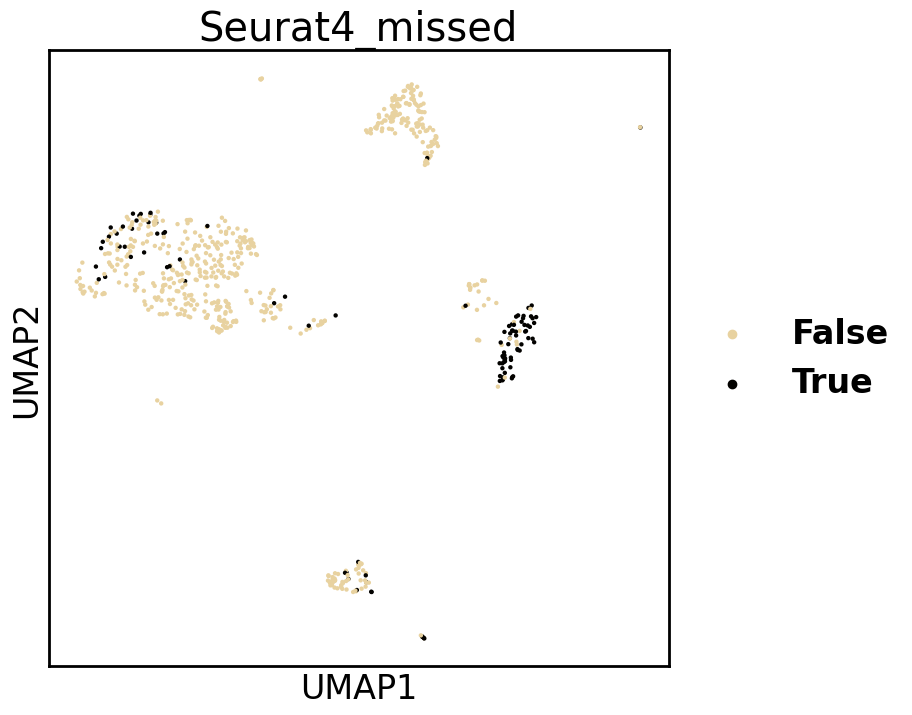

In [125]:
plt.rcParams.update({'font.size': 24, 'font.weight': 'heavy','axes.linewidth':2})
sc.pl.umap(adata_val, color = ['CD45RA_True_Label','Seurat4_predicted'],ncols = 1, palette = rb_palette, size =40)
sc.pl.umap(adata_val, color = ['Seurat4_missed'],ncols = 1, palette = bi_palette, size =40,save = 'seurat4_missed.png')

In [10]:
terms = pd.read_excel('DE_table.xlsx',index_col = 0)

In [158]:
corr_w_HNRNPLL = dict()
for i in X_train.columns:
    corr_val = spearmanr(X_train['HNRNPLL'], X_train[i])
    corr_w_HNRNPLL[i] = corr_val
corr_w_HNRNPLL_df = pd.DataFrame.from_dict(corr_w_HNRNPLL, orient='index').rename(columns={0: 'statistic', 1: 'pvalue'})

In [159]:
train_result_table = pd.DataFrame(np.zeros([6,3]))
train_result_table.index = ['SVM linear','SVM rbf','LR','stack','MLP linear SVM features','MLP rbf SVM features']
train_result_table.columns = ['Accuracy (%)','Precision (%)','Recall (%)']
test_result_table = train_result_table.copy()

In [160]:
test_prediction_table = pd.DataFrame(np.zeros([X_val.shape[0],6]))
test_prediction_table.columns = ['SVM linear','SVM rbf','LR','stack','MLP linear SVM features','MLP rbf SVM features']
train_prediction_table =pd.DataFrame(np.zeros([X_train.shape[0],5]))
train_prediction_table.columns = ['SVM linear','SVM rbf','LR','MLP linear SVM features','MLP rbf SVM features']

In [161]:
X_CV = X_train
y_CV = y_train
folds = 10
global folds
global X_CV
global y_CV
global corr_w_HNRNPLL_df
global terms

In [ ]:
_org_df = pd.DataFrame(index = adata.obs_names, columns = best_linear_mlp_features)
for i in best_linear_mlp_features:
    if i in adata.var_names:
        _org_df[i] = adata.X[:,adata.var_names == i].A
    else:
        _org_df[i] = np.zeros([adata.shape[0],1])

In [155]:
input_shape = best_linear_mlp.layers[0].input_shape

In [156]:
_prediction =  best_linear_mlp.predict(_org_df)

1046/1046 [==============================] - 1s 1ms/step


In [158]:
accuracy_score(adata.obs['CD45RA_label']=='Positive',_prediction>0.5)

0.804967718794835

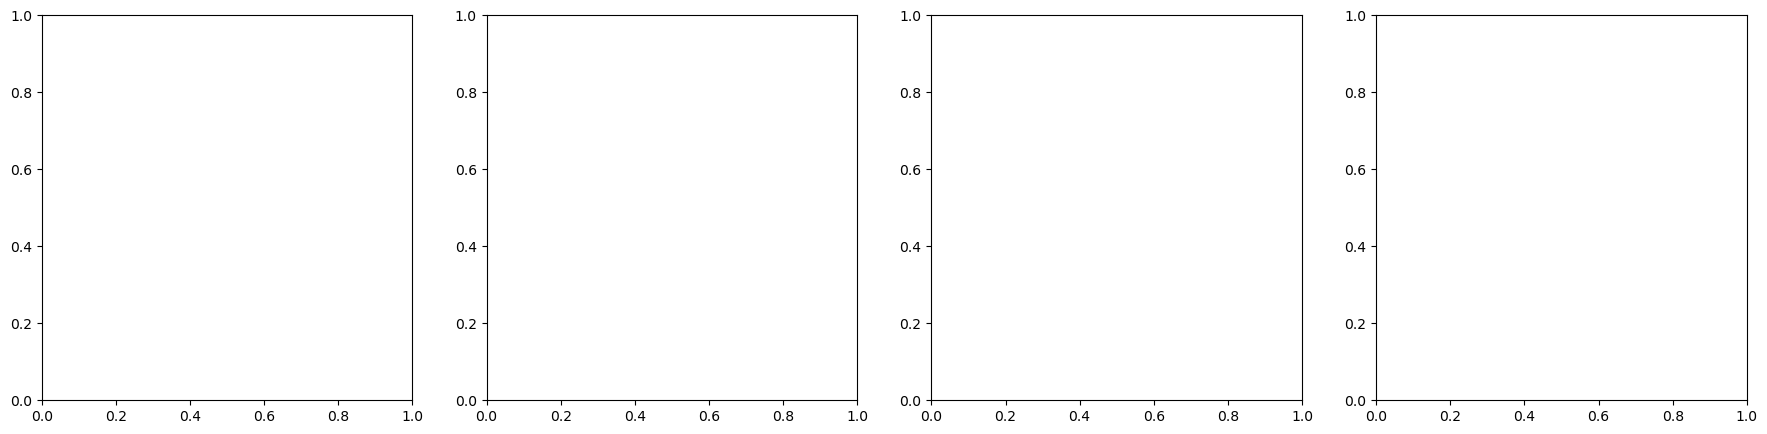

In [18]:
fig, axes = plt.subplots(1, 4, figsize=(22, 5))
feature_list = [best_linear_svm_features]

In [19]:
for ax_idx, estimator in enumerate([best_linear_svm]):
    common_params = {
    "X": X[feature_list[ax_idx]],
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 4),
    "cv": ShuffleSplit(n_splits=5, test_size=0.2, random_state=42),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
    }
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=axes[ax_idx])
    handles, label = axes[ax_idx].get_legend_handles_labels()
    axes[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    axes[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}")

In [116]:
# define the neural network architecture
def build_model(learning_rate, dropout_rate, num_hidden_layers, num_neurons):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(num_neurons, input_shape=(len(best_linear_svm_features),), activation='relu'))
    for i in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons, activation='relu'))
        model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [113]:
def extract_hyperparameters(model):
    # Extract learning rate
    learning_rate = model.optimizer.learning_rate.numpy()
    
    # Extract dropout rate and num_neurons from layers
    dropout_rate = None
    num_neurons = None
    num_hidden_layers = 0
    
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Dense):
            if num_neurons is None:  # take neurons count from the first Dense layer
                num_neurons = layer.units
            if layer.activation == tf.keras.activations.relu:
                num_hidden_layers += 1
        elif isinstance(layer, tf.keras.layers.Dropout):
            dropout_rate = layer.rate
    
    return learning_rate, dropout_rate, num_hidden_layers, num_neurons

In [ ]:
def plot_learning_curve(model, X, y, test_size=0.2, epochs=15, batch_size=32, cv=5):
    
    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size,random_state = 42)
    n_train = len(X_train)
    
    # Define training sizes and arrays to hold scores
    train_sizes = np.linspace(0.1, 1.0, 5)
    train_scores = []
    val_scores = []
    
    for train_size in train_sizes:
        train_scores_fold = []
        val_scores_fold = []
        
        for fold in range(cv):
            # Randomly sample a subset of the training data
            indices = np.random.choice(n_train, int(n_train * train_size), replace=False)
            X_train_subset = X_train.iloc[indices,:]
            y_train_subset = y_train[indices]

            learning_rate, dropout_rate, num_hidden_layers, num_neurons = extract_hyperparameters(model)
            # Use the extracted hyperparameters to build a new model
            new_model = build_model(learning_rate, dropout_rate, num_hidden_layers, num_neurons)
            new_model.fit(X_train_subset, y_train_subset, epochs=epochs, batch_size=batch_size, verbose=0)
            
            # Evaluate the model
            train_score = new_model.evaluate(X_train_subset, y_train_subset, verbose=0)
            val_score = new_model.evaluate(X_val, y_val, verbose=0)
            
            train_scores_fold.append(train_score[1])
            val_scores_fold.append(val_score[1])
        
        print(val_scores_fold)
        train_scores.append(np.mean(train_scores_fold))
        val_scores.append(np.mean(val_scores_fold))

    plt.figure()
    plt.title('Learning Curve')
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()
    
    plt.fill_between(train_sizes * n_train, 
                     train_scores - np.std(train_scores), 
                     train_scores + np.std(train_scores), alpha=0.1, color="r")
    plt.fill_between(train_sizes * n_train, 
                     val_scores - np.std(val_scores), 
                     val_scores + np.std(val_scores), alpha=0.1, color="g")
    
    plt.plot(train_sizes * n_train, train_scores, 'o-', color="r", label="Training score")
    plt.plot(train_sizes * n_train, val_scores, 'o-', color="g", label="Validation score")
    
    plt.legend(loc="best")
    time_label = time.time()
    plt.savefig('mlp_learning' + str(time_label) + '.png')

# Use the function to plot the learning curve
plot_learning_curve(best_linear_mlp, X[best_linear_mlp_features], y)

In [125]:
# define the neural network architecture
def build_model(learning_rate, dropout_rate, num_hidden_layers, num_neurons):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(num_neurons, input_shape=(len(best_rbf_svm_features),), activation='relu'))
    for i in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons, activation='relu'))
        model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

[0.8556851148605347, 0.8411078453063965, 0.8411078453063965, 0.8381924033164978, 0.8148688077926636]
[0.8790087699890137, 0.8804664611816406, 0.8906705379486084, 0.8731778264045715, 0.8892128467559814]
[0.8921282887458801, 0.8906705379486084, 0.8935859799385071, 0.8790087699890137, 0.8833819031715393]
[0.8892128467559814, 0.8965014815330505, 0.8892128467559814, 0.8979591727256775, 0.9037901163101196]
[0.8979591727256775, 0.8935859799385071, 0.8994169235229492, 0.8921282887458801, 0.8994169235229492]


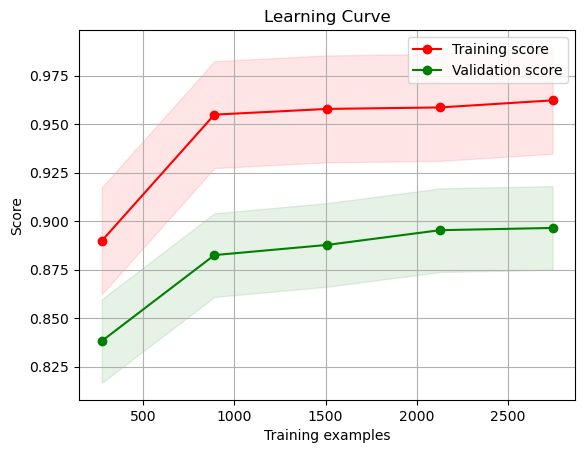

In [126]:
def plot_learning_curve(model, X, y, test_size=0.2, epochs=15, batch_size=32, cv=5):
    
    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size,random_state = 42)
    n_train = len(X_train)
    
    # Define training sizes and arrays to hold scores
    train_sizes = np.linspace(0.1, 1.0, 5)
    train_scores = []
    val_scores = []
    
    for train_size in train_sizes:
        train_scores_fold = []
        val_scores_fold = []
        
        for fold in range(cv):
            # Randomly sample a subset of the training data
            indices = np.random.choice(n_train, int(n_train * train_size), replace=False)
            X_train_subset = X_train.iloc[indices,:]
            y_train_subset = y_train[indices]

            learning_rate, dropout_rate, num_hidden_layers, num_neurons = extract_hyperparameters(model)
            # Use the extracted hyperparameters to build a new model
            new_model = build_model(learning_rate, dropout_rate, num_hidden_layers, num_neurons)
            new_model.fit(X_train_subset, y_train_subset, epochs=epochs, batch_size=batch_size, verbose=0)
            
            # Evaluate the model
            train_score = new_model.evaluate(X_train_subset, y_train_subset, verbose=0)
            val_score = new_model.evaluate(X_val, y_val, verbose=0)
            
            train_scores_fold.append(train_score[1])
            val_scores_fold.append(val_score[1])
        
        print(val_scores_fold)
        train_scores.append(np.mean(train_scores_fold))
        val_scores.append(np.mean(val_scores_fold))

    plt.figure()
    plt.title('Learning Curve')
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()
    
    plt.fill_between(train_sizes * n_train, 
                     train_scores - np.std(train_scores), 
                     train_scores + np.std(train_scores), alpha=0.1, color="r")
    plt.fill_between(train_sizes * n_train, 
                     val_scores - np.std(val_scores), 
                     val_scores + np.std(val_scores), alpha=0.1, color="g")
    
    plt.plot(train_sizes * n_train, train_scores, 'o-', color="r", label="Training score")
    plt.plot(train_sizes * n_train, val_scores, 'o-', color="g", label="Validation score")
    
    plt.legend(loc="best")
    time_label = time.time()
    plt.savefig('mlp_learning' + str(time_label) + '.png')

plot_learning_curve(best_rbf_mlp, X[best_rbf_mlp_features], y)

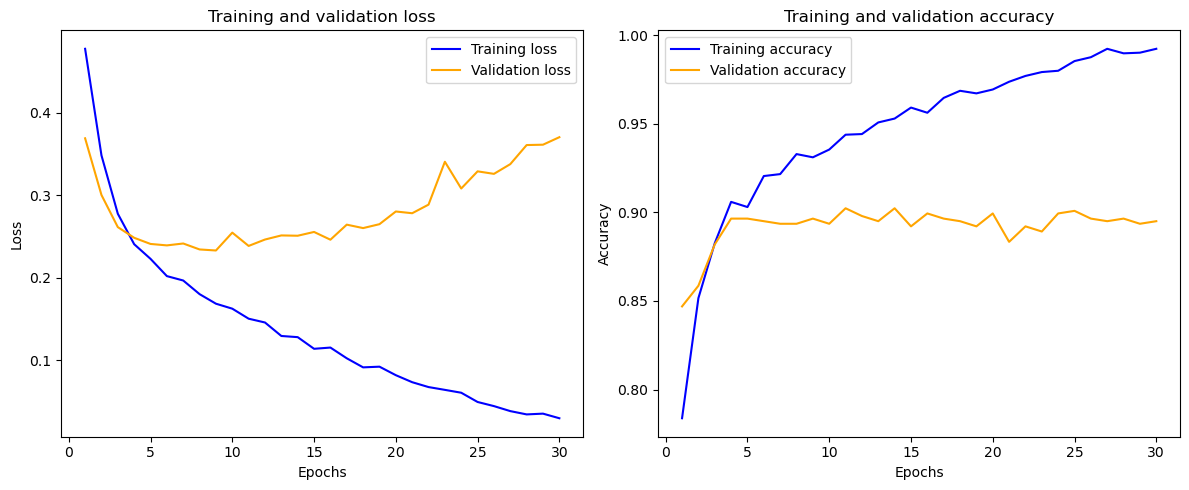

In [82]:
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

# Plotting loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'blue', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# If you also have accuracy data
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'blue', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('RBF_mlp_epochs.png',dpi = 300)

In [178]:
X_val[stack_features]

,ABCA1,ABCB1,ABCD1,ABHD17A,ABI3,AC004687.1,AC004865.2,AC005261.1,AC007952.4,AC012615.1,...,ZNF518B,ZNF595,ZNF600,ZNF618,ZNF783,ZNF853,ZNF91,ZNRF1,ZSCAN16-AS1,ZYX
192,0.0,0.000000,0.0,1.609438,0.000000,1.386294,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,1.386294,0.000000
1721,0.0,0.000000,0.0,0.000000,0.000000,0.693147,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
33,0.0,0.000000,0.0,1.098612,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
1569,0.0,0.693147,0.0,1.098612,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,1.098612,0.0,0.000000,0.000000
514,0.0,0.000000,0.0,0.693147,0.000000,0.000000,0.000000,0.0,0.693147,0.000000,...,0.0,0.0,0.0,0.693147,0.0,0.0,0.693147,0.0,0.000000,0.693147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1830,0.0,0.000000,0.0,1.386294,0.693147,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.693147,0.0,0.693147,0.000000
259,0.0,0.000000,0.0,0.000000,0.000000,0.693147,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.693147,0.000000
918,0.0,0.693147,0.0,1.609438,0.000000,0.000000,0.000000,0.0,0.000000,0.693147,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.693147,0.0,1.386294,0.693147
1160,0.0,0.000000,0.0,1.386294,0.000000,1.098612,0.693147,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000


In [195]:
y_pred_val_linear_svm = best_linear_svm.predict_proba(X_val[best_linear_svm_features])[:,1]
y_pred_val_rbf_svm = best_rbf_svm.predict_proba(X_val[best_rbf_svm_features])[:,1]
y_pred_val_lr = best_lr.predict_proba(X_val[best_lr_features])[:,1]
y_pred_val_stack = stack.predict_proba(X_val[stack_features])[:,1]
y_pred_val_mlp = best_linear_mlp.predict(X_val[best_linear_svm_features])
y_pred_val_mlp_rbf = best_rbf_mlp.predict(X_val[best_rbf_svm_features])

22/22 [==============================] - 0s 761us/step


In [196]:
y_val.shape

(686,)

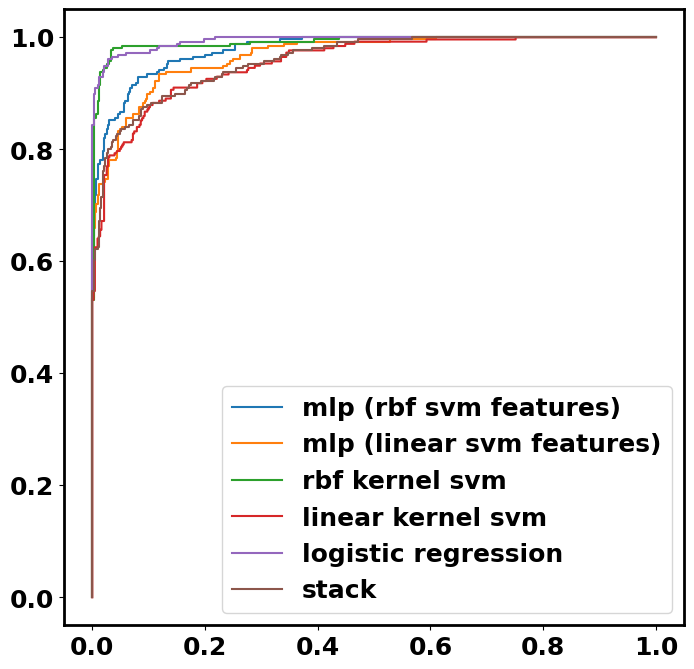

In [203]:
from sklearn.metrics import roc_curve
plt.rcParams.update({'font.size': 18, 'font.weight': 'heavy','axes.linewidth':2})
fig, ax = plt.subplots(figsize=(8, 8))

fpr1, tpr1, thresholds1 = roc_curve(y_val, y_pred_val_mlp_rbf)
ax.plot(fpr1, tpr1,  label="mlp (rbf svm features)")
fpr1, tpr1, thresholds1 = roc_curve(y_val, y_pred_val_mlp)
ax.plot(fpr1, tpr1,  label="mlp (linear svm features)")
fpr1, tpr1, thresholds1 = roc_curve(y_val, y_pred_val_rbf_svm)
ax.plot(fpr1, tpr1,  label="rbf kernel svm")
fpr1, tpr1, thresholds1 = roc_curve(y_val, y_pred_val_linear_svm)
ax.plot(fpr1, tpr1,  label="linear kernel svm")                         
fpr1, tpr1, thresholds1 = roc_curve(y_val, y_pred_val_lr)
ax.plot(fpr1, tpr1, label="logistic regression")
fpr1, tpr1, thresholds1 = roc_curve(y_val, y_pred_val_stack)
ax.plot(fpr1, tpr1,  label="stack")
ax.legend()
fig.savefig('E:/ROC.png')

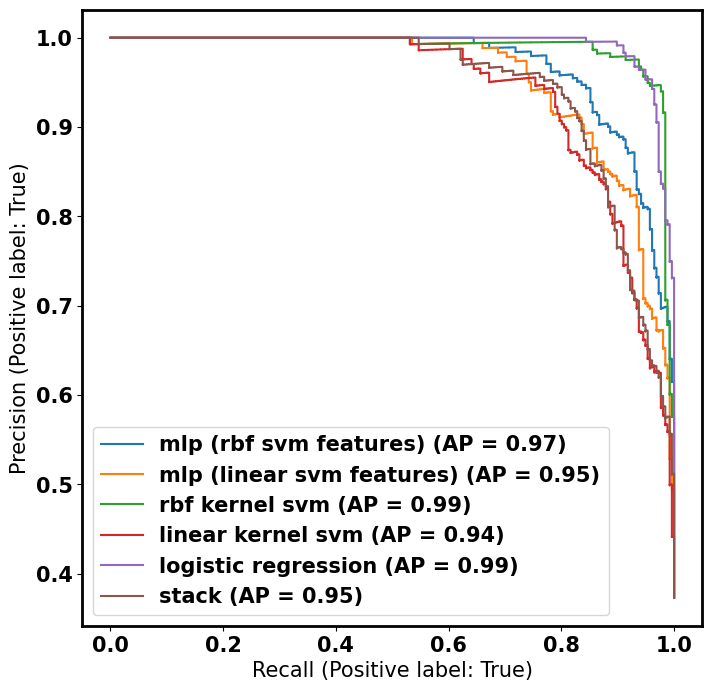

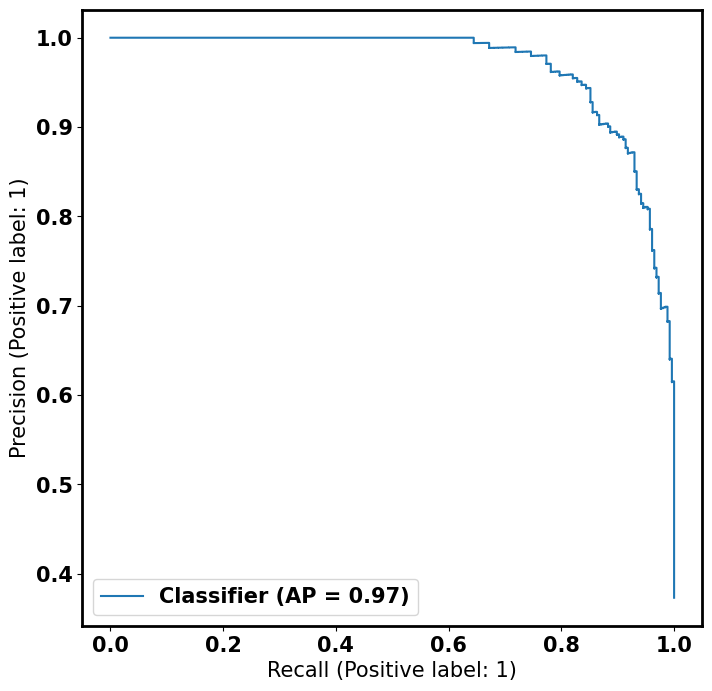

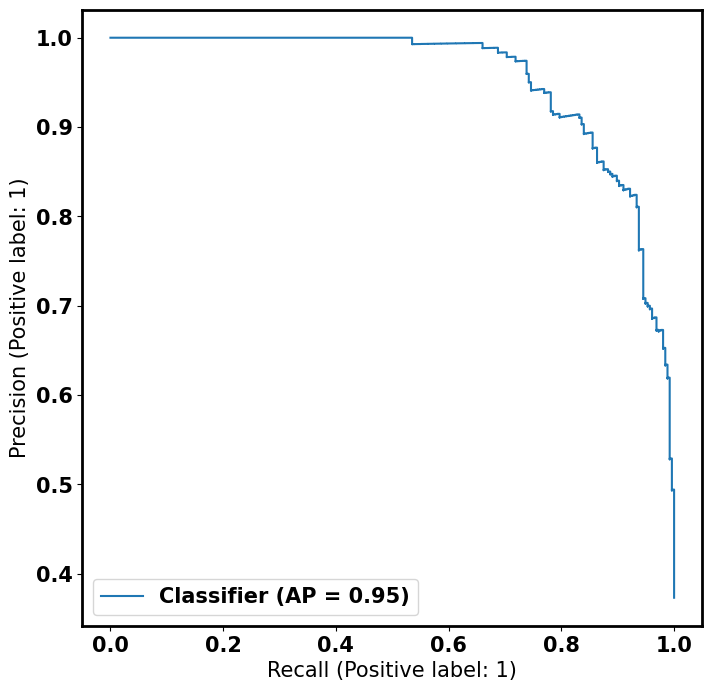

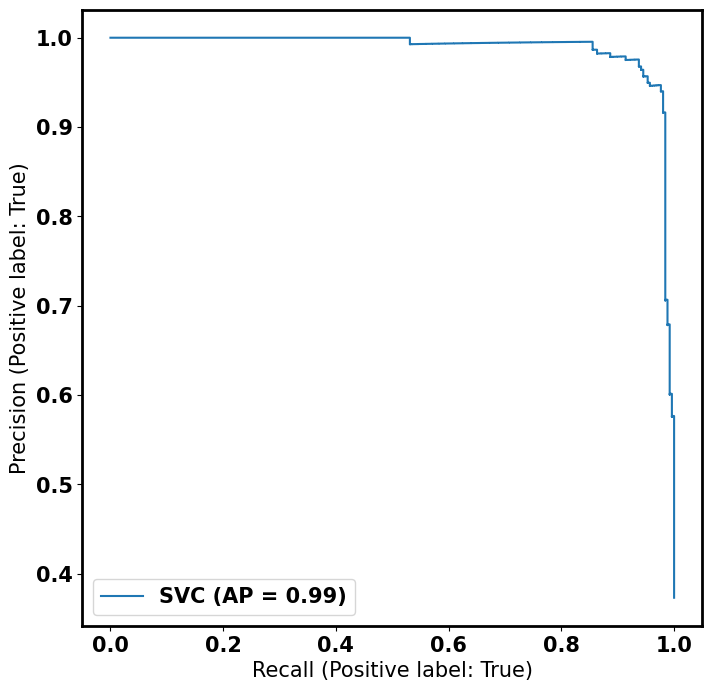

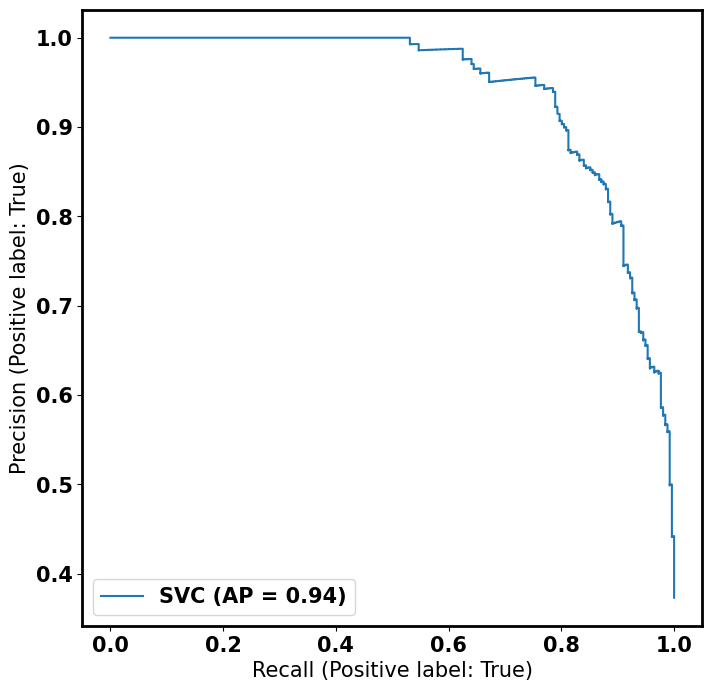

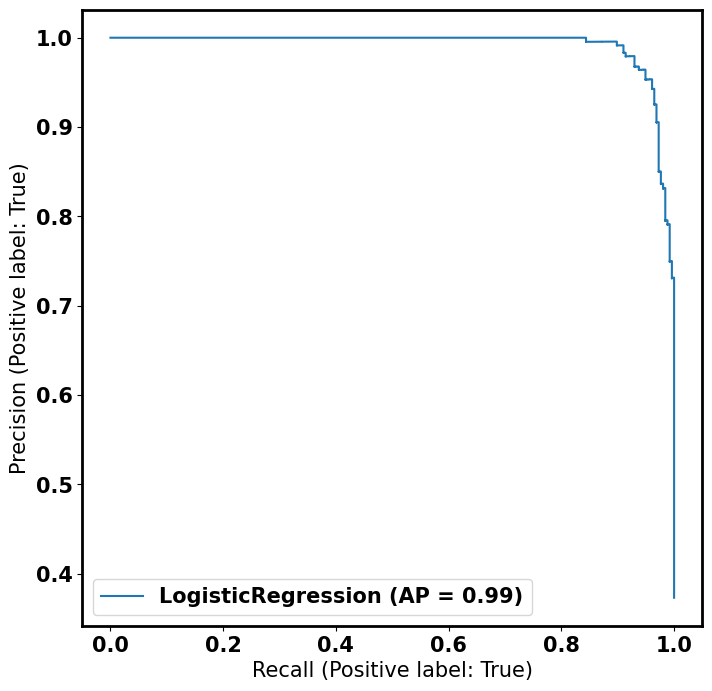

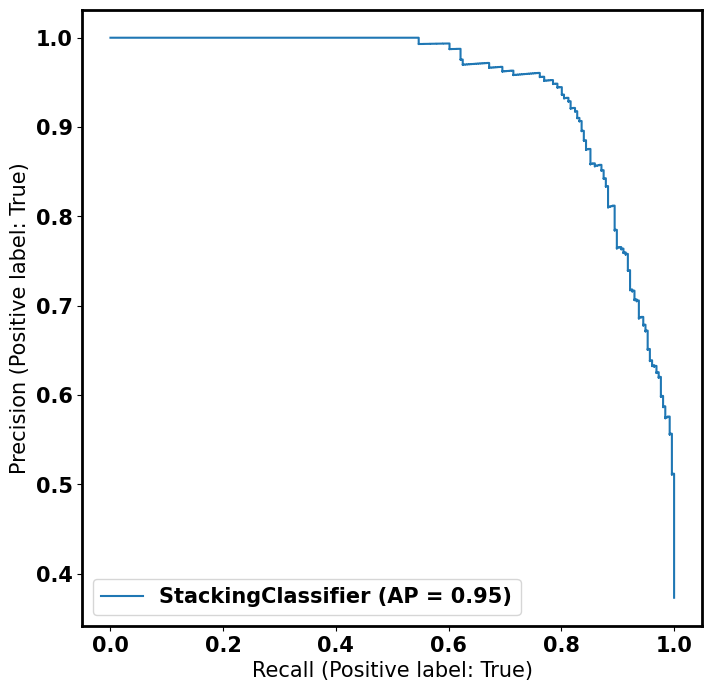

In [204]:
from sklearn.metrics import PrecisionRecallDisplay
plt.rcParams.update({'font.size': 15, 'font.weight': 'heavy','axes.linewidth':2})
fig, ax = plt.subplots(figsize=(8, 8))

display = PrecisionRecallDisplay.from_predictions(y_val, y_pred_val_mlp_rbf)
display.plot(ax=ax, name="mlp (rbf svm features)")
display = PrecisionRecallDisplay.from_predictions(y_val, y_pred_val_mlp)
display.plot(ax=ax, name="mlp (linear svm features)")
display = PrecisionRecallDisplay.from_estimator(best_rbf_svm, X_val[best_rbf_svm_features], y_val)
display.plot(ax=ax, name="rbf kernel svm")
display = PrecisionRecallDisplay.from_estimator(best_linear_svm, X_val[best_linear_svm_features], y_val)
display.plot(ax=ax, name="linear kernel svm")                         
display = PrecisionRecallDisplay.from_estimator(best_lr, X_val[best_lr_features], y_val)
display.plot(ax=ax, name="logistic regression")
display = PrecisionRecallDisplay.from_estimator(stack, X_val[stack_features], y_val)
display.plot(ax=ax, name="stack")
fig.savefig('E:/precisionrecall_val.png')